## Making reading medical abstracts easier!

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 12.92 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


## Start small and do it as you go

In [3]:
# Notice the data the data is in txt format let us see what we can do
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [4]:
import os
import matplotlib.pyplot as plt
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocessing data

In [5]:
def get_lines(filename):
  """
  Reads file and returns each line as list

  Args: filename : A string containing the target filepath

  Returns: A list of strings divided by line
  """
  with open(filename, "r") as f:
    return f.readlines()

In [6]:
# Reading training lines
train_lines = get_lines("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
train_lines[:11]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

## Now let us visualize


In [8]:
import pandas as pd

train_samples = preprocess_text_with_line_numbers("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
val_samples = preprocess_text_with_line_numbers("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt")
test_samples = preprocess_text_with_line_numbers("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt")

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


**OMG would you look at that it looks amazingly beautiful**

In [9]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

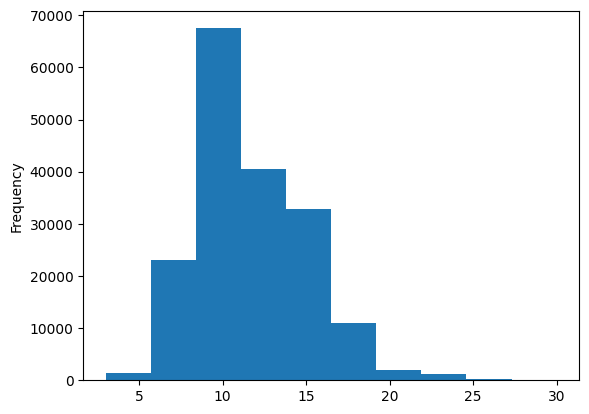

In [10]:
train_df.total_lines.plot.hist()

In [11]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [12]:
# extract labels and do label encoding

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels = label_encoder.fit_transform(test_df["target"].to_numpy())
val_labels = label_encoder.fit_transform(val_df["target"].to_numpy())

train_labels

array([3, 2, 2, ..., 4, 1, 1])

In [13]:
class_names = label_encoder.classes_
num_classes = len(class_names)

## Now time to create our baseline model with Naive Bayes

In [14]:
train_sentences = train_df["text"]
test_sentences = test_df["text"]
val_sentences = val_df["text"]

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn .pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer = 'word', binary=False)),
    ("clf", MultinomialNB(alpha=1.0, class_prior = None, fit_prior = True))
])
print(train_df["text"])
model_0.fit(train_sentences, train_labels)

0         to investigate the efficacy of @ weeks of dail...
1         a total of @ patients with primary knee oa wer...
2         outcome measures included pain reduction and i...
3         pain was assessed using the visual analog pain...
4         secondary outcome measures included the wester...
                                ...                        
180035    for the absolute change in percent atheroma vo...
180036    for pav , a significantly greater percentage o...
180037    both strategies had acceptable side effect pro...
180038    compared with standard statin monotherapy , th...
180039    ( plaque regression with cholesterol absorptio...
Name: text, Length: 180040, dtype: object


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [16]:
base_pred = model_0.predict(val_sentences)
score = model_0.score(val_sentences, val_labels)

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [18]:
calculate_results(val_labels, base_pred)

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Preparing deep models

> Create vectorizers and embeddings



In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [20]:
# sentence length how much?
sent_length = [len(sentence.split()) for sentence in train_sentences]
avg_sent_length = int(sum(sent_length) / len(sent_length))
print(len(sent_length))
avg_sent_length

180040


26

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

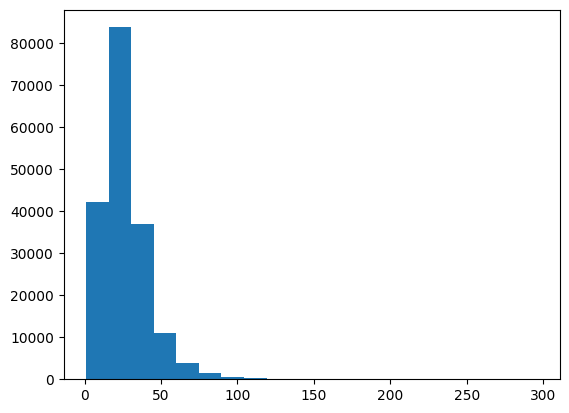

In [21]:
plt.hist(sent_length, bins=20)

In [22]:
# so let us get concept of percentiles here
# what lengh covers 95 percentile of data?

output_seq_len = int(np.percentile(sent_length, 95))
output_seq_len

55

## Time to vectorize lesgooo

In [23]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens = 68000,
                                               output_sequence_length=55,
                                               pad_to_max_tokens=True,
                                              )

In [24]:
vectorize_layer.adapt(train_sentences)

In [25]:
import random
target_sentence = random.choice(train_sentences)
print(target_sentence)
print((vectorize_layer([target_sentence])))

ph was defined as a mean pulmonary artery pressure @ mm hg .
tf.Tensor(
[[1801   10  472   25    8   57  562  543  200  234  855    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)


In [26]:
vocab = vectorize_layer.get_vocabulary()
print(len(vocab))
vocab[:10]

64841


['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

## Creating the custom embeddings

In [27]:
token_embed = layers.Embedding(input_dim = len(vocab),
                              output_dim = 128, # change this for better results training time changes
                               mask_zero=True, # more efficient computing if more zeros
                               name = "token_embedding")

In [28]:
target_sentence = random.choice(train_sentences)
print(target_sentence)
vectorized_sentence = vectorize_layer([target_sentence])
print(vectorized_sentence)
embedded_sentence = token_embed(vectorized_sentence)
print(embedded_sentence)

the primary endpoint was the duration of diarrhoea and secondary outcomes were days of hospitalisation and the percentage of children with diarrhoea after each day of treatment .
tf.Tensor(
[[   2   56  349   10    2  282    4 2852    3  151   75    9   84    4
  5073    3    2  467    4  109    7 2852   21  122  108    4   19    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)
tf.Tensor(
[[[ 0.00056796  0.00751992  0.04035801 ... -0.01928549  0.03762977
    0.01781328]
  [ 0.01835575  0.03935662  0.03215765 ...  0.02991632 -0.02813449
    0.03618577]
  [ 0.04974147  0.02628123  0.04495266 ...  0.00891509 -0.01495885
    0.00312727]
  ...
  [-0.02787     0.02154321  0.01275552 ...  0.00062485  0.0467371
    0.02341605]
  [-0.02787     0.02154321  0.01275552 ...  0.00062485  0.0467371
    0.02341605]
  [-0.02787     0.02154321  0.01275552 ...  0.00062485  0.0467371


## Need to create efficient data pipelines

**Now a very amazing thing we learned here i.e. creating tensorflow datasets**

In [29]:
print(train_sentences)
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

# takes list of strings and arrays and coverts it into a tf dataset

0         to investigate the efficacy of @ weeks of dail...
1         a total of @ patients with primary knee oa wer...
2         outcome measures included pain reduction and i...
3         pain was assessed using the visual analog pain...
4         secondary outcome measures included the wester...
                                ...                        
180035    for the absolute change in percent atheroma vo...
180036    for pav , a significantly greater percentage o...
180037    both strategies had acceptable side effect pro...
180038    compared with standard statin monotherapy , th...
180039    ( plaque regression with cholesterol absorptio...
Name: text, Length: 180040, dtype: object


In [30]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

## Prefetching datasets
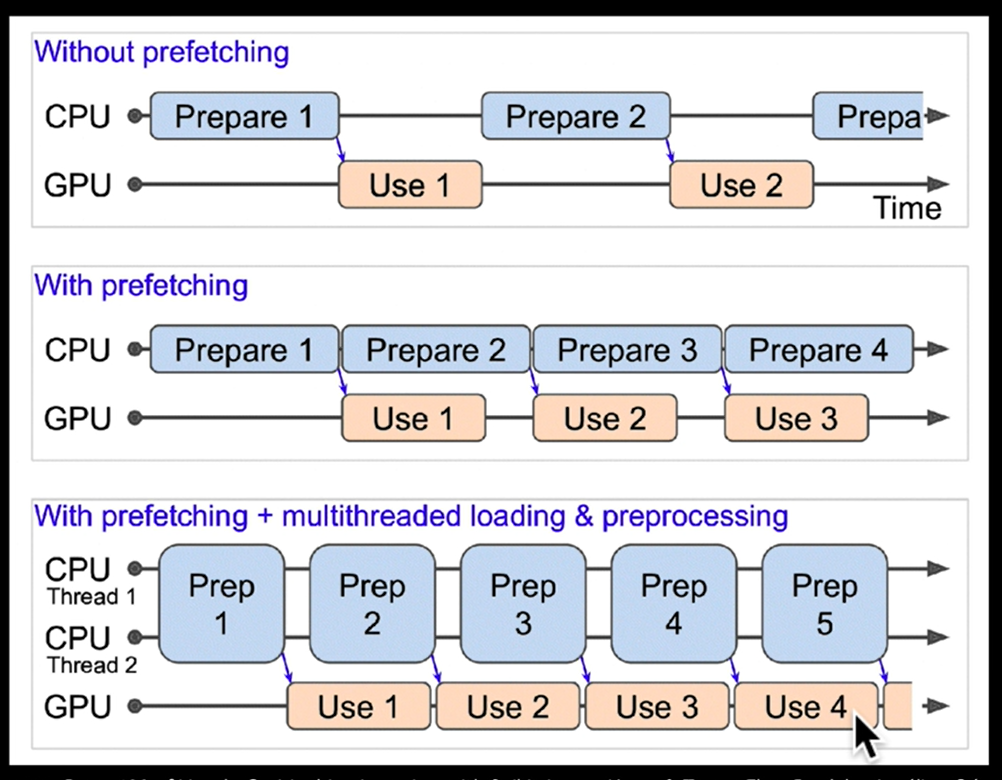

In [31]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D layer with token embeddings

In [32]:
inputs = layers.Input(shape=(1, ), dtype = tf.string)
text_vectors = vectorize_layer(inputs) # vectorize inputs
token_embeddings = token_embed(text_vectors)

x = layers.Conv1D(64, kernel_size = 5, activation="relu")(token_embeddings)  # see 5 words and form relation between them
x = layers. GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [33]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 51, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history_model_1 = model_1.fit(train_dataset,
                            steps_per_epoch = int(0.1*len(train_dataset)), # Speed ups what happens is I trained on a small part of dataset instead of full dataset to save time
                            epochs=3,
                            validation_data = valid_dataset)

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5127 - loss: 1.1799 - val_accuracy: 0.7153 - val_loss: 0.7481
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7325 - loss: 0.7181 - val_accuracy: 0.7579 - val_loss: 0.6830
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7600 - loss: 0.6473 - val_accuracy: 0.7763 - val_loss: 0.6310


In [35]:
# evaluate on valid dataset
model_1.evaluate(valid_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7731 - loss: 0.6305


[0.6310210824012756, 0.7763066291809082]

In [76]:
# predict
print(valid_dataset)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>
942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [37]:
class_names
# like 0 is background, 2 is methods

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [131]:
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)

model_1_results

{'accuracy': 77.63066202090593,
 'precision': 0.772630376090126,
 'recall': 0.7763066202090593,
 'f1': 0.7733986958404054}

## Time to create a character level embedding for out model number 2 with conv1D

In [39]:
#[i, love, tensorflow]->[i, l, o, v, e, t, e, n, s...]
train_sentences[:5]

,text
0,to investigate the efficacy of @ weeks of dail...
1,a total of @ patients with primary knee oa wer...
2,outcome measures included pain reduction and i...
3,pain was assessed using the visual analog pain...
4,secondary outcome measures included the wester...


In [40]:
def split_chars(text):
  return " ". join(list(text))

In [41]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [42]:
# split into character level datasets

train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [43]:
# average character length
chars_length = [len(sentence) for sentence in train_sentences]
mean_chars = np.mean(chars_length)
most_chars = np.percentile(chars_length, 95)
most_chars

290.0

## Now text vectorization for character level let's gooo
## BUT we also want the different characters we can have a-z and all punctuation let's see how we dp that

In [44]:
import string
alphabets = string.punctuation + string.digits+string.ascii_lowercase
alphabets  # this covers all keyboard characters

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789abcdefghijklmnopqrstuvwxyz'

In [45]:
num_char_tokens = len(alphabets)
num_char_tokens = num_char_tokens + 2  # 2 for unknown and space

In [46]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = num_char_tokens,
                                    output_sequence_length = int(most_chars),
                                    name = "char_vectorizer"
                                    )

In [47]:
char_vectorizer.adapt(train_chars)

In [48]:
char_vocab = char_vectorizer.get_vocabulary()
print(len(char_vocab))
print(char_vocab[:5])
char_vocab[-5:]

28
['', '[UNK]', 'e', 't', 'i']


['k', 'x', 'z', 'q', 'j']

In [49]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = num_char_tokens,
                                    output_sequence_length = int(most_chars),
                                    name = "char_vectorizer",
                                    standardize = None
                                    )

In [50]:
char_vectorizer.adapt(train_chars)

In [51]:
char_vocab = char_vectorizer.get_vocabulary()
print(char_vocab[:5])
len(char_vocab)  # now that includes both alphabets and puctuations as well

['', '[UNK]', 'e', 't', 'i']


57

In [52]:
random_train = random.choices(train_chars)
vectorized_random = char_vectorizer(random_train)
vectorized_random[0]

<tf.Tensor: shape=(290,), dtype=int64, numpy=
array([11, 12,  4,  6,  4, 11,  4,  5,  6,  9, 10,  2,  9, 11,  8,  4, 23,
        2, 10,  3, 13,  2,  4,  8,  8,  7, 12,  2,  4,  6, 14,  8,  7, 22,
        4, 10,  4,  6, 18,  2,  5,  8, 12, 20, 14,  5, 12, 12,  4,  5,  3,
        4, 22,  2, 11,  5,  8,  2,  5,  9, 13,  5, 22,  4,  6, 18,  3, 13,
        8,  2,  2, 10,  4,  9,  3,  4,  6, 11,  3,  8,  7, 12,  2,  9,  4,
        6,  3, 13,  2,  7, 16,  3, 14,  5,  3,  4,  2,  6,  3,  9,  2,  3,
        3,  4,  6, 18, 38, 28, 19, 27, 15,  5,  6,  5, 18,  4,  6, 18,  9,
       20, 15, 14,  3,  7, 15,  9,  3,  7,  4, 15, 14,  8,  7, 22,  2, 17,
       16,  6, 11,  3,  4,  7,  6,  5, 12,  9,  3,  5,  3, 16,  9,  5,  6,
       10,  5,  9,  5, 23,  8,  4, 10, 18,  2,  3,  7,  7,  3, 13,  2,  8,
        4,  9,  9, 16,  2,  9, 36, 28, 19, 27,  2,  6, 18,  5, 18,  4,  6,
       18, 14,  5,  3,  4,  2,  6,  3,  9,  4,  6,  2, 15,  7,  3,  4,  7,
        6,  5, 12, 21,  7,  8, 29,  3,  7, 17,  5, 11,

In [53]:
char_embed = tf.keras.layers.Embedding(
    len(vocab),
    56,
    embeddings_regularizer=None,
    embeddings_constraint=None,
    mask_zero=True,
    weights=None,
    lora_rank=None,
)

In [54]:
char_embed(vectorized_random)

<tf.Tensor: shape=(1, 290, 56), dtype=float32, numpy=
array([[[-0.04654877,  0.00431691,  0.03832803, ..., -0.01895888,
         -0.00468151, -0.03761686],
        [-0.04940432, -0.03496456,  0.00042752, ...,  0.01873058,
         -0.01025592, -0.0393224 ],
        [-0.03841562, -0.02674567, -0.00313286, ..., -0.01240532,
          0.04338342, -0.0023222 ],
        ...,
        [-0.03013991, -0.02361699, -0.0253942 , ..., -0.0036425 ,
         -0.02462023, -0.04541309],
        [-0.03018228, -0.01092909, -0.02355257, ...,  0.01189337,
         -0.00814605, -0.04201419],
        [ 0.03505449,  0.01716889,  0.01392094, ..., -0.02240987,
         -0.03680532, -0.03801645]]], dtype=float32)>

In [55]:
inputs = layers.Input(shape=(1, ), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)

x = layers.Conv1D(64, kernel_size = 5, activation="relu")(char_embeddings)
# see 5 words and form relation between them
x = layers. GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [56]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [57]:
history_model_3 = model_3.fit(train_char_dataset,
                            steps_per_epoch = int(0.1*len(train_char_dataset)), # Speed ups what happens is I trained on a small part of dataset instead of full dataset to save time
                            epochs=3,
                            validation_data = val_char_dataset)

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3846 - loss: 1.4015 - val_accuracy: 0.5181 - val_loss: 1.1794
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5214 - loss: 1.1671 - val_accuracy: 0.5338 - val_loss: 1.1522
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5336 - loss: 1.1423 - val_accuracy: 0.5460 - val_loss: 1.1190


## Now it is time to combine pretrained model_embeddings and character embeddings

basically ``model_1`` plus `model_2`

In [58]:
token_inputs = layers.Input(shape=(1,), dtype = tf.string, name="token_input")
token_embeddings = token_embed(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                       outputs = token_output)


char_inputs = layers.Input(shape=(1,), dtype = tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)
char_output_reshaped = layers.Reshape((-1, char_model.output.shape[-1]))(char_model.output)

In [59]:
# now let us concat model 1 and 3

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_output_reshaped])

combined_dropout = layers.Dropout(0.5)(token_char_concat)

combined_dense = layers.Dense(128, activation='relu')(combined_dropout)

final_dropout = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)


model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs = output_layer,
                         name="model_4_char_embeddings")

In [60]:
model_4.summary()

Model: "model_4_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 290, 56)        │      3,631,096 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_embedding           │ (None, 1, 128)         │      8,299,648 │ token_input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 48)             │         15,552 │ embedding[1][0],       │
│ (Bidirectional)           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 128)         │         16,512 │ token_embedding[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 48)          │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 1, 176)         │              0 │ dense_2[0][0],         │
│ (Concatenate)             │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1, 176)         │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 128)         │         22,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1, 128)         │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 5)           │            645 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,986,109 (45.72 MB)

 Trainable params: 11,986,109 (45.72 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Combine token and character data into a tf.data dataset

In [62]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [63]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [64]:
print(train_char_token_dataset)

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


In [65]:
model_1_pred_probs

array([[3.48289132e-01, 6.32458031e-02, 2.44831160e-01, 3.09239209e-01,
        3.43947187e-02],
       [3.12965084e-03, 1.63532747e-03, 9.57938075e-01, 3.99388140e-03,
        3.33031192e-02],
       [4.69999097e-04, 2.65785656e-03, 8.28550160e-01, 3.20185267e-04,
        1.68001726e-01],
       ...,
       [2.89361668e-03, 3.75986323e-02, 5.17911837e-02, 1.72317738e-03,
        9.05993342e-01],
       [9.01888870e-03, 3.75267826e-02, 1.03882134e-01, 5.06632449e-03,
        8.44505906e-01],
       [9.48566850e-03, 5.09322703e-01, 6.09927475e-02, 1.17419790e-02,
        4.08456922e-01]], dtype=float32)

In [66]:
model_1_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [67]:
model_1.save("skimmer_model.keras")

In [68]:
loaded_model = tf.keras.models.load_model("skimmer_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [69]:
loaded_model_pred_probs = loaded_model.predict(valid_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [70]:
load_pred = tf.argmax(loaded_model_pred_probs, axis=1)
load_pred

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [71]:
load_model_results = calculate_results(val_labels, load_pred)
load_model_results

{'accuracy': 77.63066202090593,
 'precision': 0.772630376090126,
 'recall': 0.7763066202090593,
 'f1': 0.7733986958404054}

In [72]:
train_lines = get_lines("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
train_samples = preprocess_text_with_line_numbers("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
train_df = pd.DataFrame(train_samples)

text = (
    "This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated "
    "heart failure (ADHF). A post hoc analysis was conducted using data from the Evaluation Study of Congestive Heart Failure "
    "and Pulmonary Artery Catheterization Effectiveness (ESCAPE). Liver function tests (LFTs) were measured at multiple time "
    "points from baseline, at discharge, and up to several months follow-up. Survival analyses assessed the association between "
    "admission Model of End-Stage Liver Disease Excluding International Normalized Ratio (MELD-XI) scores and patient outcome. "
    "There was a high prevalence of abnormal baseline (admission) LFTs, including abnormal albumin levels, aspartate transaminase, "
    "alanine transaminase, and total bilirubin.\n\n"
    "The percentage of patients with abnormal LFTs decreased significantly from baseline to follow-up. When mean hemodynamic "
    "profiles were compared in patients with abnormal versus normal LFTs, elevated total bilirubin was associated with a "
    "significantly lower cardiac index and higher central venous pressure. Multivariable analyses revealed that patients with "
    "elevated MELD-XI scores had an increased risk of death, rehospitalization, or transplantation after adjusting for baseline "
    "LFTs, age, sex, race, body mass index, diabetes, and systolic blood pressure.\n\n"
    "Abnormal LFTs are common in the ADHF population and serve as a dynamic marker of an impaired hemodynamic state. Elevated "
    "MELD-XI scores are associated with poor outcomes among patients admitted with ADHF."
)


In [73]:
lines = text.splitlines()

results = []

lines

['This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure (ADHF). A post hoc analysis was conducted using data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness (ESCAPE). Liver function tests (LFTs) were measured at multiple time points from baseline, at discharge, and up to several months follow-up. Survival analyses assessed the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio (MELD-XI) scores and patient outcome. There was a high prevalence of abnormal baseline (admission) LFTs, including abnormal albumin levels, aspartate transaminase, alanine transaminase, and total bilirubin.',
 '',
 'The percentage of patients with abnormal LFTs decreased significantly from baseline to follow-up. When mean hemodynamic profiles were compared in patients with abnormal versus normal LFTs, elevated total bilirubin was 

In [111]:
import pandas as pd
import tensorflow as tf

sample_text = (
    "This research aimed to investigate the impact of elevated glucose levels on kidney function in diabetic patients admitted with acute complications.\n"
    "A retrospective analysis was conducted using data from the National Diabetic Health Study.\n"
    "Kidney function markers (serum creatinine and estimated glomerular filtration rate) were measured at baseline, discharge, and a 6-month follow-up.\n"
    "Statistical analyses were performed to examine the relationship between elevated baseline glucose levels and patient outcomes.\n"
    "A high incidence of abnormal kidney function markers was observed at admission (serum creatinine: 45%, eGFR: 35%).\n"
    "The percentage of patients with abnormal kidney markers reduced significantly from baseline to the 6-month follow-up.\n"
    "Patients with elevated baseline glucose levels had a higher risk of progression to chronic kidney disease.\n"
    "Comparative analysis revealed that those with high glucose levels exhibited lower eGFR (45 vs 60 mL/min/1.73 m², P < 0.05) and higher serum creatinine (1.5 vs 1.1 mg/dL, P = 0.03).\n"
    "After multivariable adjustments, elevated glucose levels were associated with a 1.8-fold increased risk of kidney disease progression.\n"
    "Abnormal kidney function markers are prevalent among diabetic patients with acute complications and are indicators of long-term risk.\n"
    "Elevated glucose levels at admission are associated with poor outcomes and increased risk of kidney disease progression."
)

# Check if the text contains newline characters
if '\n' in sample_text:
    lines = sample_text.splitlines()
else:
    lines = sample_text.split('.')

# Create a DataFrame from the lines
lines_df = pd.DataFrame(lines)

# Create a TensorFlow dataset
lines_dataset = tf.data.Dataset.from_tensor_slices(lines_df).batch(1)

# Further batch the dataset for processing
lines_dataset = lines_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Print the output
print(lines_df)
print(lines_dataset)

                                                    0
0   This research aimed to investigate the impact ...
1   A retrospective analysis was conducted using d...
2   Kidney function markers (serum creatinine and ...
3   Statistical analyses were performed to examine...
4   A high incidence of abnormal kidney function m...
5   The percentage of patients with abnormal kidne...
6   Patients with elevated baseline glucose levels...
7   Comparative analysis revealed that those with ...
8   After multivariable adjustments, elevated gluc...
9   Abnormal kidney function markers are prevalent...
10  Elevated glucose levels at admission are assoc...
<_PrefetchDataset element_spec=TensorSpec(shape=(None, None, 1), dtype=tf.string, name=None)>


In [112]:
loaded_model_pred_probs = loaded_model.predict(lines_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [113]:
loaded_model_probs = tf.argmax(loaded_model_pred_probs, axis=1)
loaded_model_probs

<tf.Tensor: shape=(11,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 4, 4, 0, 1])>

In [114]:
preds = class_names[loaded_model_probs]
for pred in preds:
  print(pred)
for line in sample_text.splitlines():
  print(line)

OBJECTIVE
METHODS
METHODS
METHODS
RESULTS
RESULTS
RESULTS
RESULTS
RESULTS
BACKGROUND
CONCLUSIONS
This research aimed to investigate the impact of elevated glucose levels on kidney function in diabetic patients admitted with acute complications.
A retrospective analysis was conducted using data from the National Diabetic Health Study.
Kidney function markers (serum creatinine and estimated glomerular filtration rate) were measured at baseline, discharge, and a 6-month follow-up.
Statistical analyses were performed to examine the relationship between elevated baseline glucose levels and patient outcomes.
A high incidence of abnormal kidney function markers was observed at admission (serum creatinine: 45%, eGFR: 35%).
The percentage of patients with abnormal kidney markers reduced significantly from baseline to the 6-month follow-up.
Patients with elevated baseline glucose levels had a higher risk of progression to chronic kidney disease.
Comparative analysis revealed that those with high

In [115]:
for line, pred in zip(sample_text.splitlines(), preds):
  print(f"{pred}: \n{line}")

OBJECTIVE: 
This research aimed to investigate the impact of elevated glucose levels on kidney function in diabetic patients admitted with acute complications.
METHODS: 
A retrospective analysis was conducted using data from the National Diabetic Health Study.
METHODS: 
Kidney function markers (serum creatinine and estimated glomerular filtration rate) were measured at baseline, discharge, and a 6-month follow-up.
METHODS: 
Statistical analyses were performed to examine the relationship between elevated baseline glucose levels and patient outcomes.
RESULTS: 
A high incidence of abnormal kidney function markers was observed at admission (serum creatinine: 45%, eGFR: 35%).
RESULTS: 
The percentage of patients with abnormal kidney markers reduced significantly from baseline to the 6-month follow-up.
RESULTS: 
Patients with elevated baseline glucose levels had a higher risk of progression to chronic kidney disease.
RESULTS: 
Comparative analysis revealed that those with high glucose levels

In [116]:
grouped_sentences = []
current_heading = None
current_section = []

for sentence, heading in zip(sample_text.splitlines(), preds):
    if heading != current_heading:
        if current_section:
            grouped_sentences.append((current_heading, current_section))
            current_section = []
        current_heading = heading

    current_section.append(sentence)

if current_section:
    grouped_sentences.append((current_heading, current_section))

for heading, sentences in grouped_sentences:
    print(f"{heading}:")
    for sentence in sentences:
        print(f"  - {sentence}")
    print("\n")

OBJECTIVE:
  - This research aimed to investigate the impact of elevated glucose levels on kidney function in diabetic patients admitted with acute complications.


METHODS:
  - A retrospective analysis was conducted using data from the National Diabetic Health Study.
  - Kidney function markers (serum creatinine and estimated glomerular filtration rate) were measured at baseline, discharge, and a 6-month follow-up.
  - Statistical analyses were performed to examine the relationship between elevated baseline glucose levels and patient outcomes.


RESULTS:
  - A high incidence of abnormal kidney function markers was observed at admission (serum creatinine: 45%, eGFR: 35%).
  - The percentage of patients with abnormal kidney markers reduced significantly from baseline to the 6-month follow-up.
  - Patients with elevated baseline glucose levels had a higher risk of progression to chronic kidney disease.
  - Comparative analysis revealed that those with high glucose levels exhibited lower 

In [133]:
def skimmer(text):
  # Check if the text contains newline characters
  if '\n' in text:
      lines = text.splitlines()
  else:
      lines = lines.replace('. ', '\n')
      lines = text.splitlines()

  lines_df = pd.DataFrame(lines)

  lines_dataset = tf.data.Dataset.from_tensor_slices(lines_df).batch(1)

  # Further batch the dataset for processing
  lines_dataset = lines_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

  loaded_model_pred_probs = loaded_model.predict(lines_dataset)
  loaded_model_probs = tf.argmax(loaded_model_pred_probs, axis=1)
  preds = class_names[loaded_model_probs]

  grouped_sentences = {}
  current_heading = None
  current_section = []

  for sentence, heading in zip(text.splitlines(), preds):
      # If the heading changes, finalize the current section
      if heading != current_heading:
          if current_section:
              if current_heading in grouped_sentences:
                  grouped_sentences[current_heading].extend(current_section)
              else:
                  grouped_sentences[current_heading] = current_section
              current_section = []
          current_heading = heading

      current_section.append(sentence)

  if current_section:
      if current_heading in grouped_sentences:
          grouped_sentences[current_heading].extend(current_section)
      else:
          grouped_sentences[current_heading] = current_section

  return grouped_sentences

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [139]:
def helper_skimmer_text(skimmed_text):
    grouped_sentences = skimmed_text
    for heading, sentences in grouped_sentences.items():
        print(f"{heading}:")
        for sentence in sentences:
            print(f"  - {sentence}")
        print("\n")
print("INPUT:\n", sample_text)
print("\nOUTPUT:")
skimmed= skimmer(sample_text)
helper_skimmer_text(skimmed)

INPUT:
 This research aimed to investigate the impact of elevated glucose levels on kidney function in diabetic patients admitted with acute complications.
A retrospective analysis was conducted using data from the National Diabetic Health Study.
Kidney function markers (serum creatinine and estimated glomerular filtration rate) were measured at baseline, discharge, and a 6-month follow-up.
Statistical analyses were performed to examine the relationship between elevated baseline glucose levels and patient outcomes.
A high incidence of abnormal kidney function markers was observed at admission (serum creatinine: 45%, eGFR: 35%).
The percentage of patients with abnormal kidney markers reduced significantly from baseline to the 6-month follow-up.
Patients with elevated baseline glucose levels had a higher risk of progression to chronic kidney disease.
Comparative analysis revealed that those with high glucose levels exhibited lower eGFR (45 vs 60 mL/min/1.73 m², P < 0.05) and higher serum

In [132]:
new = "Hypertension is a chronic condition characterized by elevated arterial pressure, often unnoticed until serious complications arise, affecting millions globally. It manifests primarily as essential hypertension with no identifiable cause or secondary hypertension stemming from underlying conditions like kidney disease or hormonal imbalances. Contributing factors include poor dietary habits, excessive sodium intake, and low potassium levels, alongside physical inactivity leading to obesity, excessive alcohol consumption, and tobacco use, which damage blood vessels and strain the heart. Often dubbed the silent killer, hypertension presents few symptoms, though individuals may experience headaches, dizziness, and shortness of breath, with severe cases leading to life-threatening complications such as heart disease, stroke, kidney damage, and vision loss. Diagnosis involves multiple blood pressure readings over time, supplemented by tests to rule out other health issues. Management combines lifestyle modifications—dietary changes promoting fruits and vegetables, regular exercise to maintain a healthy weight, and stress reduction techniques—alongside pharmacological interventions like diuretics to lower blood volume, ACE inhibitors to relax blood vessels, beta-blockers to reduce heart workload, and calcium channel blockers to prevent calcium entry into cells. A proactive and comprehensive approach can significantly mitigate the risks associated with high blood pressure, enhancing overall health and quality of life, and underlining the importance of regular monitoring and intervention."
new = new.replace('. ', '\n')
skimmed = skimmer(new)
helper_skimmer_text(skimmed)

                                                   0
0  Hypertension is a chronic condition characteri...
1  It manifests primarily as essential hypertensi...
2  Contributing factors include poor dietary habi...
3  Often dubbed the silent killer, hypertension p...
4  Diagnosis involves multiple blood pressure rea...
5  Management combines lifestyle modifications—di...
6  A proactive and comprehensive approach can sig...
<_PrefetchDataset element_spec=TensorSpec(shape=(None, None, 1), dtype=tf.string, name=None)>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
BACKGROUND:
  - Hypertension is a chronic condition characterized by elevated arterial pressure, often unnoticed until serious complications arise, affecting millions globally
  - It manifests primarily as essential hypertension with no identifiable cause or secondary hypertension stemming from underlying conditions like kidney disease or hormonal imbalances
  - Often dubbed the silent killer, hypertension presents few symptoms, though indiv